In [1]:
import numpy as np
import scipy.stats
import scipy as scp
import sklearn
import sklearn.covariance
import sklearn.cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections 
%matplotlib inline

# Make data

In [2]:
mean = np.zeros(6)
cov = [[   1, .29, .49, .10, .30,  0],
        [ .29,   1,-.49, .49, .40,  0],
        [ .49,-.49,   1,   0,   0,  0],
        [ .10, .49,   0,   1,   0,  0],
        [ .30, .40,   0,   0,   1,  0],
        [   0,   0,   0,   0,   0,  1]]

In [3]:
X = scp.stats.multivariate_normal.rvs(mean=mean,cov=cov,size=300,random_state=5)
#x4 correlate with x6
X[:,3] += 0.6*X[:,5]
#x5 correlate with x6
X[:,4] += 0.6*X[:,5]
df_X = pd.DataFrame(X,columns=['X{0}'.format(i+1) for i in range(6)])

# Check Data

To understand the data by looking at the pair plot

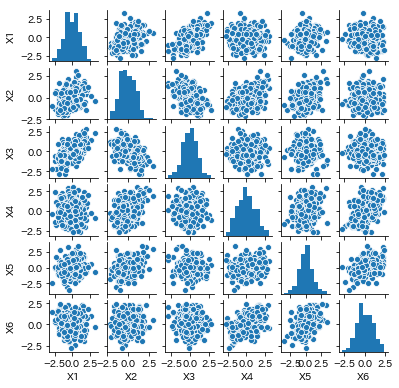

In [4]:
f = sns.pairplot(df_X)
f.fig.set_figheight(5)
f.fig.set_figwidth(5)

Pseudo correlation appears in the plot of X4 vs X6

Determine the covariance matrix with normal method as follow:   
\begin{eqnarray}   
    \Sigma ={\rm Cov}({\bf X}) = {\rm E}\left[ {\rm ( \bf X - {\rm E}[X] )( \bf X - {\rm E}[X] )^{\rm T}  }\right]
\end{eqnarray}   
Correlation matrix as folow:   
\begin{eqnarray}   
    {\rm C} &=& D\Sigma D \\
    D_{ij} &=& ({\rm diag}({\rm \Sigma}))^{-1/2}\Sigma\,({\rm diag}({\rm \Sigma}))^{-1/2}
\end{eqnarray}  

In [5]:
Cov_nom = df_X.cov()
Pre_nom = np.matrix(Cov_nom)**-1

Text(0.5, 1.0, 'Covariance matrix')

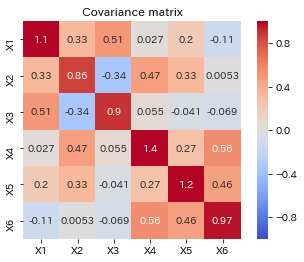

In [6]:
h = sns.heatmap(Cov_nom,cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.set_title('Covariance matrix')

Text(0.5, 1.0, 'Correlation matrix')

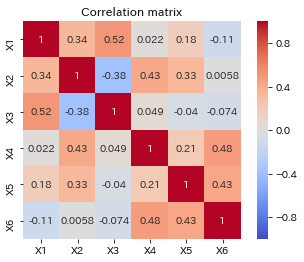

In [7]:
h = sns.heatmap(df_X.corr(),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.set_title('Correlation matrix')

In [8]:
# check pandas correlation function
def cov2corr(cov):
    cov_nom = np.array(cov)
    D = np.diag(np.power(np.diag(np.array(cov_nom)),-0.5))
    return np.dot(np.dot(D,cov_nom),D)
#pd.DataFrame(np.dot(np.dot(np.diag(np.power(np.diag(Cov_nom**-1),0.5)),np.matrix(Cov_nom)),np.diag(np.power(np.diag(Cov_nom**-1),0.5))))

partial correlation matrix - is often used as a method of finding pseudo correlation.    
partial correlation matrix define as follow:   
\begin{eqnarray}   
    r_{ij,k} = \frac{r_{ij} - r_{ki}r_{kj}}{\sqrt{1-r_{ki}^2}\sqrt{1-r_{kj}^2}}
\end{eqnarray}
$r_{ij,k}$ is the correlation coefficient between "$x_i$ excluding the influence of $x_k$" and "$x_j$ excluding the influence of $x_k$".   
$r_{ij}$ is the correlation coefficient between components $x_i$ and $x_j$.

In [9]:
def cov2partialcorr(cov):
    omega=np.linalg.inv(np.array(cov))
    D=np.diag(np.power(np.diag(omega),-0.5))
    partialcorr=-np.dot(np.dot(D,omega),D)
    #convert diagonal component　from -1 to 1
    partialcorr+=2*np.eye(cov.shape[0])
    return partialcorr

Text(0.5, 1.0, 'partialcorrelation matrix')

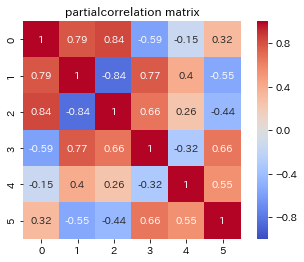

In [10]:
h = sns.heatmap(cov2partialcorr(Cov_nom),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.set_title('partialcorrelation matrix')

Calculating the partial correlation matrix using the covariance matrix calculated from the data is affected by noise,    
so the data structure is not well understood.

# Graphical Lasso

A multigraph assuming a multivariate normal distribution is called a Gaussian graphic model.   
By using the precision matrix $\Lambda = (\Sigma^{-1})$which is a parameter of this distribution, 
we can see the relationship of variables as a graphic model.    
That is, the i and j elements $\lambda_{ij}$.   
If it is not 0, there is a direct correlation between $x_i$ and $x_j$.

Given that data x follows a multivariate normal distribution, the distribution of the data is as follows:

\begin{eqnarray}
    \mathcal{N}({\bf x}|{\bf 0},\Lambda^{-1}) \sim \frac{|\Lambda|^{1/2}}{(2\pi)^{M/2}}\exp\left(-\frac{1}{2}{\bf x}^{t}\Lambda {\bf x}\right)
\end{eqnarray}

In order to obtain a sparse precision matrix, the posterior distribution is calculated from the data assuming the prior distribution of the Laplacian distribution.
Posterior distribution:   

\begin{eqnarray}   
   p(\Lambda |{\bf D}) &\propto&  p(\Lambda)\prod^{N-1}_{i=0}\mathcal{N}({\bf x}^{(i)}| {\bf 0},\Lambda^{-1})　\\
   {\bf D} &=& \left\{ {\bf x}^{(i)}\right\}_{i=0}^{N-1}
\end{eqnarray}   

Therefore, the estimated of $\Lambda$ ($\hat \Lambda$) is :

\begin{eqnarray}   
   \hat\Lambda = {\rm arg} \max_\Lambda \left\{ \ln {\rm det}\Lambda-{\rm tr}({\rm S}\Lambda) - \alpha||\Lambda||_{1} \right\}
\end{eqnarray}    

S is the sample variance matrix.

In [11]:
alpha = 0.2
model = sklearn.covariance.GraphicalLasso(alpha=alpha,
                                           max_iter=100,                     
                                           verbose=True,
                                           assume_centered = True)
model.fit(df_X)

[graphical_lasso] Iteration   0, cost  2.80e+01, dual gap 4.965e-01
[graphical_lasso] Iteration   1, cost  2.79e+01, dual gap -3.057e-04
[graphical_lasso] Iteration   2, cost  2.79e+01, dual gap -5.331e-06


GraphicalLasso(alpha=0.2, assume_centered=True, enet_tol=0.0001, max_iter=100,
        mode='cd', tol=0.0001, verbose=True)

Text(0.5, 1.0, 'Graphical Lasso covariance matrix')

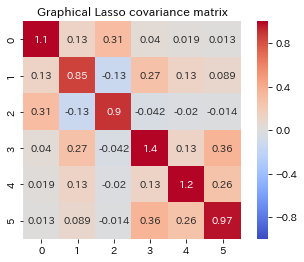

In [12]:
h = sns.heatmap(model.covariance_,cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.set_title('Graphical Lasso covariance matrix')

Text(0.5, 1.0, 'Graphical Lasso correlation matrix')

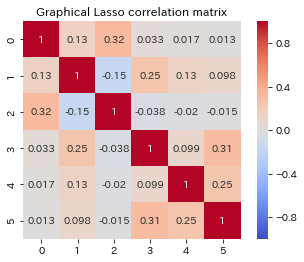

In [13]:
h = sns.heatmap(cov2corr(model.covariance_),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.set_title('Graphical Lasso correlation matrix')

Text(0.5, 1.0, 'partialcorrelation matrix')

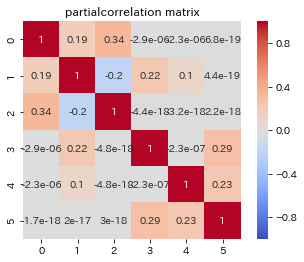

In [14]:
h = sns.heatmap(cov2partialcorr(model.covariance_),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.set_title('partialcorrelation matrix')

# Versus Markov graph

Visualize Markov graph from sparse matrix.

[参考](https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py)

Feature value clustering with affinity propagation using covariance matrix.

In [15]:
_, labels = sklearn.cluster.affinity_propagation(model.covariance_)
n_labels = labels.max()
names = df_X.columns.values
for i in range(n_labels+1):
    print('Cluster {0}: {1}'.format(i+1,names[labels==i]))

Cluster 1: ['X1' 'X3']
Cluster 2: ['X2' 'X4' 'X6']
Cluster 3: ['X5']


Locally Linear Embedding

In [16]:
node_position_model = sklearn.manifold.LocallyLinearEmbedding(n_components=2, eigen_solver='dense', n_neighbors=5)
embedding = node_position_model.fit_transform(df_X.T).T
d = 1./np.sqrt(np.diag(model.precision_))
partialcorr = cov2partialcorr(model.covariance_)
non_zero = (np.abs(np.triu(partialcorr,k=1))>0.02)

In [17]:
np.where(non_zero)

(array([0, 0, 1, 1, 1, 3, 4]), array([1, 2, 2, 3, 4, 5, 5]))

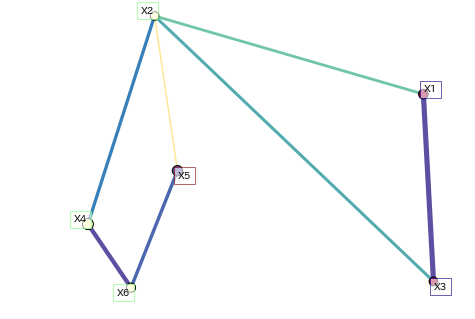

In [18]:
fig = plt.figure(1)
fig.clf()
ax = fig.add_axes([0,0,1,1])
ax.axis('off')
ax.scatter(embedding[0], embedding[1], s=100*d**2,edgecolors='k', c=labels,cmap='Spectral')

start_idx, end_idx = np.where(non_zero)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partialcorr[non_zero])
lc = matplotlib.collections.LineCollection(segments,
                                           zorder=0, cmap=plt.cm.Spectral,
                                           norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.jet(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

# Make scripts

In [19]:
import GraphicalLasso_MarkovGraph

In [20]:
alpha =0.2
model = GraphicalLasso_MarkovGraph.GraphicalLasso(alpha=alpha,
                                                  max_iter=100,                     
                                                  verbose=True,
                                                  assume_centered = True)

In [21]:
model.fit(df_X)

[graphical_lasso] Iteration   0, cost  2.80e+01, dual gap 4.965e-01
[graphical_lasso] Iteration   1, cost  2.79e+01, dual gap -3.057e-04
[graphical_lasso] Iteration   2, cost  2.79e+01, dual gap -5.331e-06


GraphicalLasso(alpha=0.2, assume_centered=True, enet_tol=0.0001, max_iter=100,
        mode='cd', tol=0.0001, verbose=True)

Text(0.5, 1.0, 'partialcorrelation matrix')

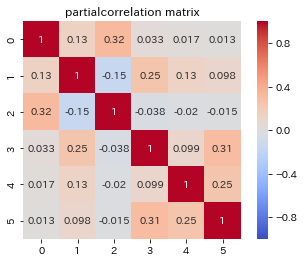

In [24]:
h = GraphicalLasso_MarkovGraph.heatmap(cov2corr(model.covariance_),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.set_title('partialcorrelation matrix')

In [25]:
Markov = GraphicalLasso_MarkovGraph.MarkovGraph(X=df_X,model=model)

Cluster 1: ['X1' 'X3']
Cluster 2: ['X2' 'X4' 'X6']
Cluster 3: ['X5']


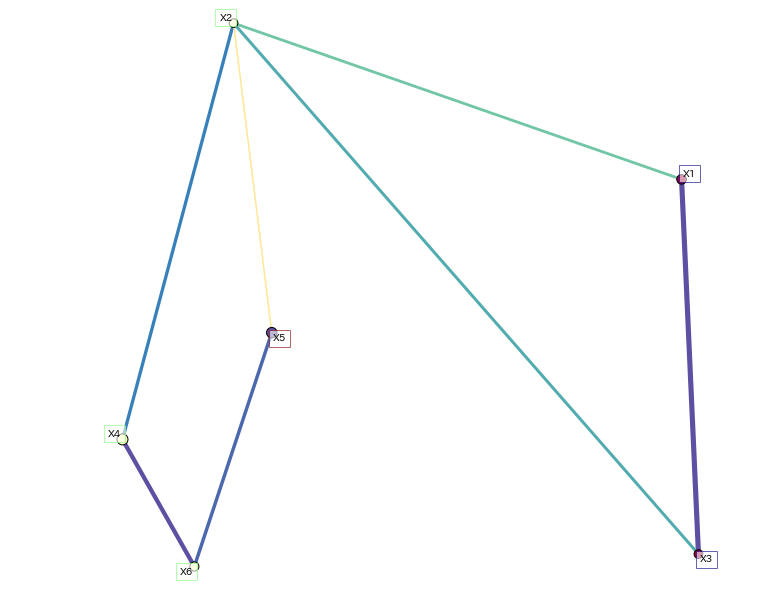

In [26]:
fig,ax = Markov.plot()
fig.savefig('./MarkovGraph.png')

In [27]:
pos = {'X1':[0,1],
       'X2':[np.sqrt(3),0.5],
       'X3':[np.sqrt(3),-0.5],
       'X4':[-np.sqrt(3),-0.5],
       'X5':[0,-1],
       'X6':[-np.sqrt(3),0.5]}

In [28]:
Markov.set_node_position(pos)

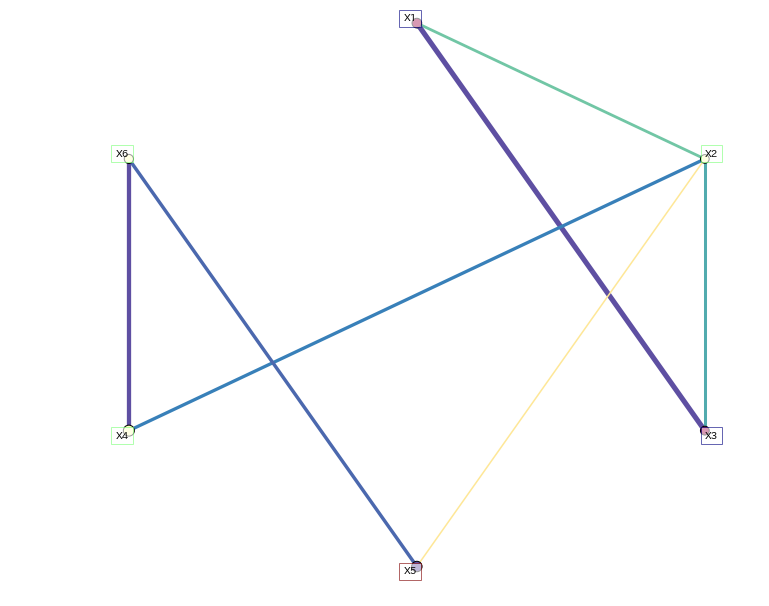

In [29]:
fig,ax = Markov.plot()
fig.savefig('./MarkovGraph_original_coordinate.png')